## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

if 0 == len(objpoints):
    print('length 0 objpoints')
else:
    print('objpoints: ', objpoints)


    
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def makeCalibrationList():
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
#     print('images: ', images)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(5)
        else:
            print('False ret, meaing find chessboard corners failed: ', fname)
         
    cv2.destroyAllWindows()
    return corners

corners = makeCalibrationList()

img = cv2.imread('camera_cal/calibration1.jpg')
#print('img :', type(img) )

# Do camera calibration given object points and image points
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)



length 0 objpoints
False ret, meaing find chessboard corners failed:  camera_cal/calibration4.jpg
False ret, meaing find chessboard corners failed:  camera_cal/calibration1.jpg
False ret, meaing find chessboard corners failed:  camera_cal/calibration5.jpg


## And so on and so forth...

In [2]:
# Define a class Frame to remember some data in one frame.

class Frame():
    def __init__(self):
        pass
        
        
frame = Frame()

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        

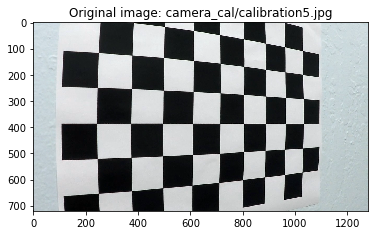

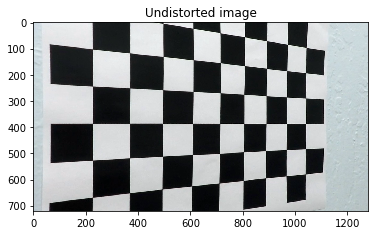

In [4]:
# undistort the image using pre-calculated "calibration datas".
def undistortImg(image):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    #cv2.imwrite('calibration_wide/test_undist.jpg',dst)
    frame.undistorted = undistorted
    return undistorted


filename = 'camera_cal/calibration5.jpg'
image = cv2.imread('camera_cal/calibration5.jpg')
#filename = 'test_images/test5.jpg'
#image = mpimg.imread(filename)

undistorted = undistortImg(image)
title = 'Original image: ' + filename
plt.title(title)
plt.imshow(image)
plt.show()

plt.imshow(undistorted)
plt.title('Undistorted image')
plt.show()
#mpimg.imsave('./writeup/undistorted-test5.jpg')


In [5]:
# In this cell I define functions doing

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    sobel = cv2.Sobel(l_channel, cv2.CV_64F, 'x' == orient, 'y' == orient)
    
    abs_sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# https://discussions.udacity.com/t/identifying-good-lanes/243822/18?u=sun.pochin
# Thresholding R channel of RGB color space.
def rgb_r_thresh(img, thresh):
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    
    # Threshold color channel
    binary = np.zeros_like(r_channel)
    binary[(r_channel >= thresh[0]) & (r_channel <= thresh[1])] = 1
    return binary

# Thresholding G channel of RGB color space.
def rgb_g_thresh(img, thresh):
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    
    # Threshold color channel
    binary = np.zeros_like(g_channel)
    binary[(g_channel >= thresh[0]) & (g_channel <= thresh[1])] = 1
    return binary

    
# Thresholding L channel of HSL color space.
def hsl_l_thresh(img, l_thresh):
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    return l_binary


# Thresholding S channel of HSL color space.
def hsl_s_thresh(img, s_thresh):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary
    
# Thresholding S channel of HSV color space.
def hsv_s_thresh(img, s_thresh):
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary
    

# Thresholding V channel of HSV color space.
def hsv_v_thresh(img, thresh):
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    # Threshold color channel
    channel = v_channel
    binary = np.zeros_like(v_channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary
    

undistorted : 


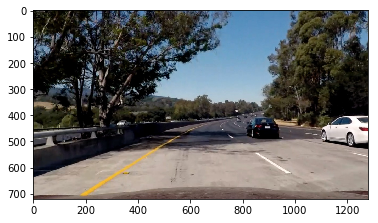

combined : 


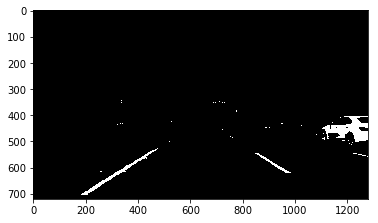

In [6]:
def thresholding(img):
    # hls color space, l channel
    s_thresh = (200, 255)
    l_binary = hsl_l_thresh(img, s_thresh)
    
    r_binary = rgb_r_thresh(img, (210, 255) )
    g_binary = rgb_g_thresh(img, (210, 255) )
    # combined_binary need to be reset to all zeros.
    combined_binary = np.zeros_like(r_binary)
#     combined_binary[(s_binary == 1) | (l_binary == 1) | (sxbinary == 1)] = 1
    combined_binary[(r_binary == 1) | (g_binary == 1) | (l_binary == 1) ] = 1

#     print('hls color space, l channel : ')
#     plt.imshow(l_binary, cmap='gray')
#     plt.show()
    
#    hsv_s_binary = hsv_s_thresh(img, s_thresh)

#     print('hls color space, s channel : ')
#     plt.imshow(s_binary, cmap='gray')
#     plt.show()
    
# #     print('Sobel X : ')
#     plt.imshow(sxbinary, cmap='gray')
#     plt.show()

#    frame.colorgrad = combined_binary
    return combined_binary

# test code:
filename = 'test_images/test5.jpg'
image = mpimg.imread(filename)
undistorted = undistortImg(image)
colorgrad = thresholding(undistorted)
print('undistorted : ')
plt.imshow(undistorted)
plt.show()
print('combined : ')
plt.imshow(colorgrad, cmap='gray')
plt.show()


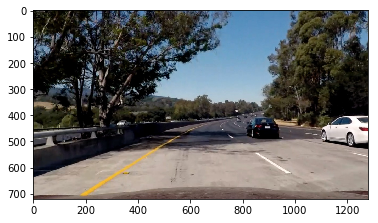

src : [[ 200  720]
 [1130  720]
 [ 720  470]
 [ 570  470]] shape:  (4, 2)
dst : [[320 720]
 [980 720]
 [980   0]
 [320   0]] shape:  (4, 2)
img.shape : (720, 1280, 3)
warped.shape : (720, 1280, 3)


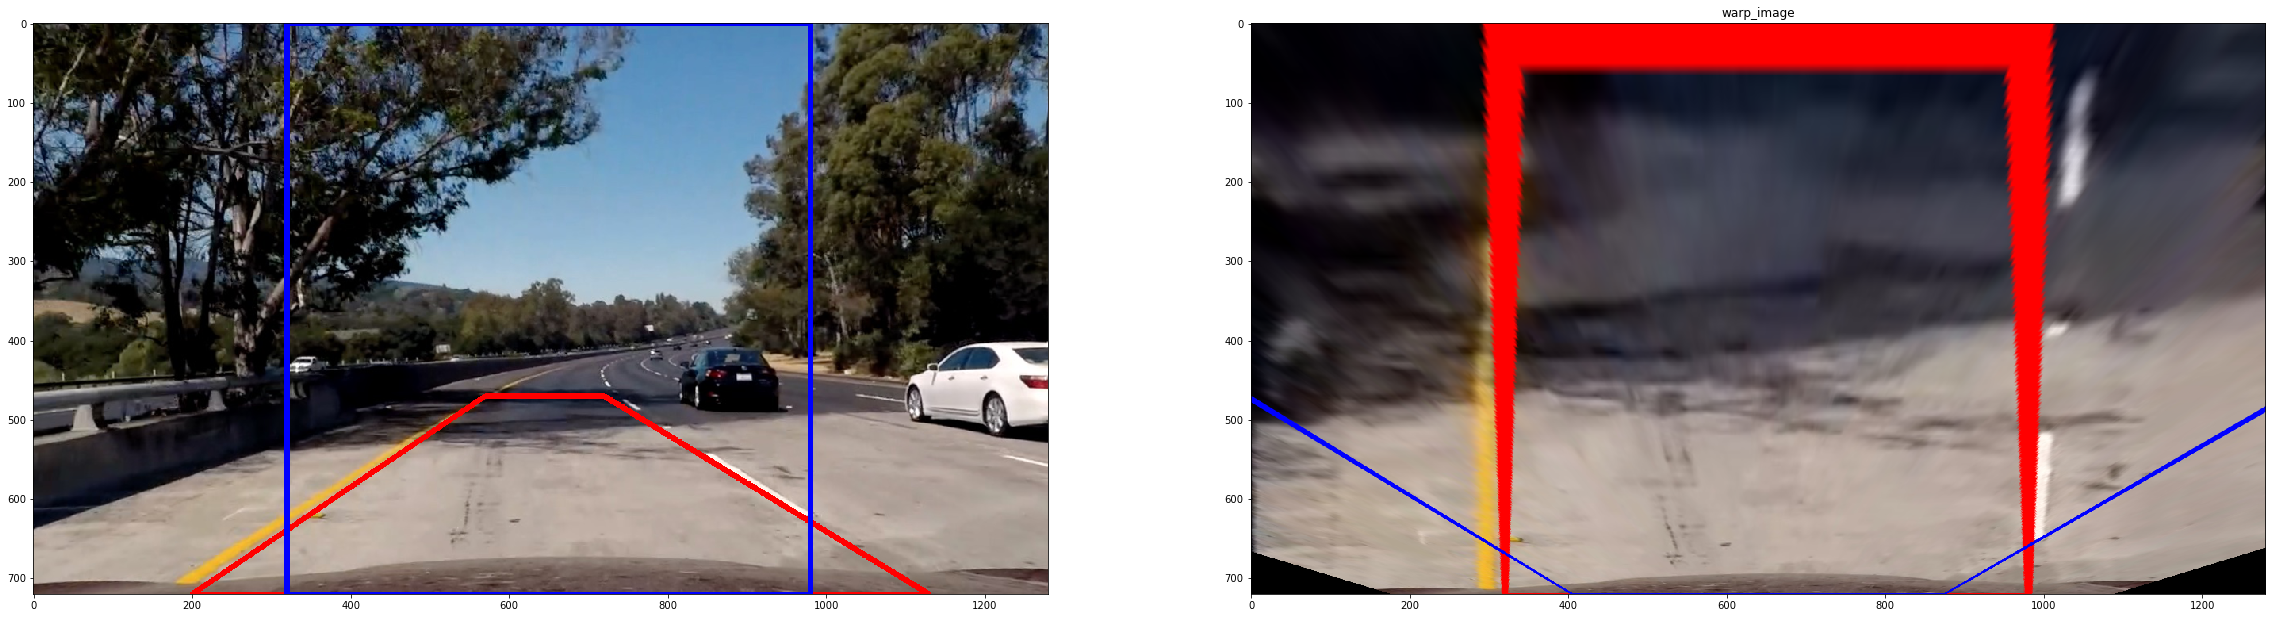

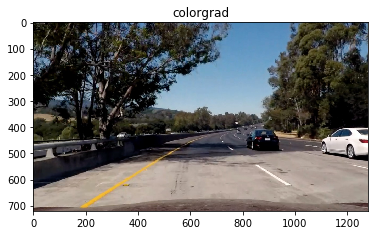

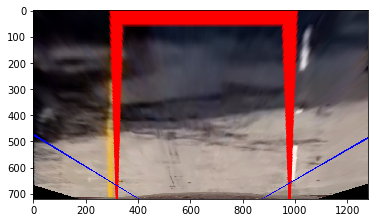

In [7]:

def warp_image(colorgrad, src, dst, debug = False):
    img = colorgrad.copy()
    # from discussion forum.
    # https://discussions.udacity.com/t/perspective-transform/235255/7
    
    if (True == debug):
        print('src :', src, 'shape: ', src.shape)
        print('dst :', dst, 'shape: ', dst.shape)
        ## plot this and see that lines are properly chosen
        cv2.polylines(img, [src], True, (255, 0, 0), 5)
        cv2.polylines(img, [dst], True, (0, 0, 255), 5)
    src = np.float32( src.tolist() )
    dst = np.float32( dst.tolist() )
    
    ## M is the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    frame.Minv = Minv
    
    image_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, dsize = image_size, flags = cv2.INTER_LINEAR)
    frame.binary_warped = warped
    
    if (True == debug):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 15)) 
        print('img.shape :', img.shape)
        print('warped.shape :', warped.shape)
        ax1.imshow(img)
        ax2.imshow(warped)
        plt.title('warp_image')
        plt.show()
        plt.title('colorgrad')
        plt.imshow(colorgrad)
        plt.show()
    return warped, M, Minv


# test 
filename = 'test_images/test5.jpg'
image = mpimg.imread(filename)

undistorted = undistortImg(image)
plt.imshow(undistorted)
plt.show()
# colorgrad = thresholding(undistorted) #(image, (180, 255), (60, 100) )
# plt.imshow(colorgrad)
# plt.show()

top_left = [570, 470]
top_right = [720, 470]
bottom_right = [1130, 720]
bottom_left = [200, 720]
src = np.array([bottom_left, bottom_right, top_right, top_left])

top_left_dst = [320, 0]
top_right_dst = [980, 0]
bottom_right_dst = [980, 720]
bottom_left_dst = [320, 720]
dst = np.array([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])

# another possible src and dst.
# w,h = 1280, 720
# x,y = 0.5*w, 0.8*h
# src = np.float32([[200./1280*w, 720./720*h],
#               [453./1280*w, 547./720*h],
#               [835./1280*w, 547./720*h],
#               [1100./1280*w, 720./720*h]])
# dst = np.float32([[(w-x)/2., h ],
#               [(w-x)/2., 0.82*h ],
#               [(w+x)/2., 0.82*h ],
#               [(w+x)/2., h ]])

warped, M, Minv = warp_image(undistorted, src, dst, True)
plt.imshow(warped)
plt.show()


In [8]:
# 33 finding the lanes
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a
def fitlanes(Debug = False):
    binary_warped = frame.binary_warped
#     print('binary_warped.shape :', binary_warped.shape )
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2 :,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    if (Debug):
        print('out_img.shape :', out_img.shape )
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if (Debug):
        print('midpoint :', midpoint, 'leftx_base :', leftx_base, 'rightx_base :', rightx_base )
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    if (Debug):
        print('nonzero :', nonzero, 'nonzeroy :', nonzeroy, nonzeroy.shape, 'nonzerox :', nonzerox, nonzerox.shape )
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
#    margin = 100
    margin = 150
    frame.margin = margin
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        try:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        except:
            print(out_img.shape, win_xleft_low, win_y_low, win_xleft_high, win_y_high)
        try:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        except:
            print(out_img.shape, win_xright_low, win_y_low, win_xright_high,win_y_high)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    #     print('good_left_inds: ', good_left_inds, 'good_right_inds: ', good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    frame.out_img = out_img
    frame.nonzero = nonzero
    frame.left_lane_inds = left_lane_inds
    frame.right_lane_inds = right_lane_inds
    frame.left_fit = left_fit
    frame.right_fit = right_fit
    
    return left_fit, right_fit

In [9]:
import math
def drawfit(debug = False):
    binary_warped = frame.binary_warped
    left_fit = frame.left_fit
    right_fit = frame.right_fit
    
    out_img = frame.out_img
    left_lane_inds = frame.left_lane_inds
    right_lane_inds = frame.right_lane_inds
    nonzero = frame.nonzero
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     print('binary_warped.shape[0]-1 : ', binary_warped.shape[0]-1)
#     print('binary_warped.shape[0] : ', binary_warped.shape[0])

#     print('ploty: ', ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # how to calculate ce
    # https://discussions.udacity.com/t/estimation-of-vehicle-position/229967
    car_pos = binary_warped.shape[1] / 2
    lane_center = (left_fitx[0] + right_fitx[0]) / 2
    offset_in_meter = (lane_center - car_pos) * xm_per_pix
    # Now our radius of curvature is in meters
    if (True == debug):
        print('y_eval : ', y_eval)
        print('left_fit_cr[0] : ', left_fit_cr[0], 'right_fit_cr[0] : ', right_fit_cr[0])
        print('car_pos :', car_pos, 'lane_center :', lane_center)
        print('x axis offset in meters:', offset_in_meter)
    # Example values: 632.1 m    626.2 m
    frame.left_curverad = left_curverad
    frame.right_curverad = right_curverad
    frame.offset_in_meter = offset_in_meter

    if (True == debug):
        plt.imshow(out_img)
        plt.title('draw fitting lanes')
        plt.show()

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        print('left_fit: ', left_fit)
        print('right_fit: ', right_fit)

    frame.left_fitx = left_fitx
    frame.right_fitx = right_fitx
    frame.ploty = ploty
    
    return left_fitx, right_fitx, ploty, out_img



In [10]:
# 33. https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a
# this step draws the windows on the poly-fitted lane curves.
def drawwindow(debug = False):
    binary_warped = frame.binary_warped
    left_fit = frame.left_fit
    right_fit = frame.right_fit
    
    out_img = frame.out_img
    left_lane_inds = frame.left_lane_inds
    right_lane_inds = frame.right_lane_inds
    nonzero = frame.nonzero
    left_fitx = frame.left_fitx
    right_fitx = frame.right_fitx
    margin = frame.margin
    ploty = frame.ploty

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if (True == debug):
        plt.title('drawwindow')
        plt.imshow(result)
        plt.show()


In [11]:
# 36. : https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/7ee45090-7366-424b-885b-e5d38210958f
# Todo 
def drawwarpback(Debug = False):
    left_fitx = frame.left_fitx
    right_fitx = frame.right_fitx
    ploty = frame.ploty
    undistorted = frame.undistorted

    # Create an image to draw the lines on\n", 
    warped = frame.binary_warped
    Minv = frame.Minv
    if Debug:
        print('Minv: ', Minv)
        print('frame.Minv: ', frame.Minv)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()\n", 
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])  
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
    pts = np.hstack((pts_left, pts_right))
    if Debug:
        print('pts_left: ', pts_left, 'pts shape: ', pts.shape) 

    # Draw the lane onto the warped blank image\n", 
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    if Debug:
        plt.imshow(color_warp)
        plt.title('color_warp') 
        plt.show()
        print('image.shape :', image.shape)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)\n", 
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    if Debug:
        plt.imshow(newwarp)
        plt.title('newwarp')
        plt.show()
    # Combine the result with the original image\n", 
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    result = cv2.putText(result, "Left curve radius : {}".format(math.floor(frame.left_curverad)),
                            (20, 40), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 255, 0), 3)
    result = cv2.putText(result, "Right curve radius : {}".format(math.floor(frame.right_curverad)),
                            (20, 80), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 255, 0), 3)
    result = cv2.putText(result, "Position of the car : {:.2f}".format(frame.offset_in_meter),
                            (20, 120), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 255, 0), 3)
    
    
    if Debug:
        plt.imshow(result) 
        plt.title('weighted')
        plt.show()

    frame.warped_combined = result
    return result



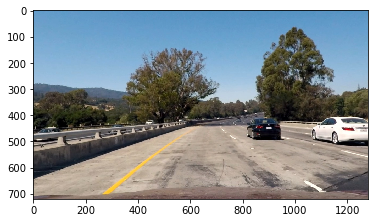

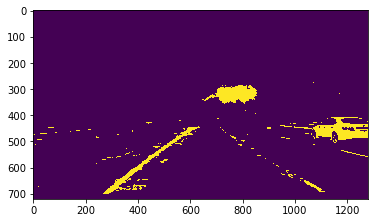

warpped shape:  (720, 1280)


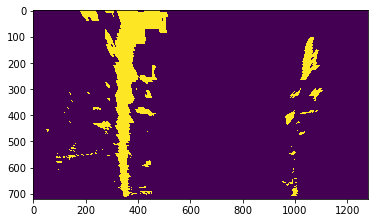

out_img.shape : (720, 1280, 3)
midpoint : 640 leftx_base : 348 rightx_base : 994
nonzero : (array([  0,   0,   0, ..., 710, 710, 710]), array([177, 178, 179, ..., 358, 359, 360])) nonzeroy : [  0   0   0 ..., 710 710 710] (72911,) nonzerox : [177 178 179 ..., 358 359 360] (72911,)
y_eval :  719.0
left_fit_cr[0] :  0.000616712516351 right_fit_cr[0] :  0.000309015133328
car_pos : 640.0 lane_center : 742.436858508
x axis offset in meters: 0.541451966397


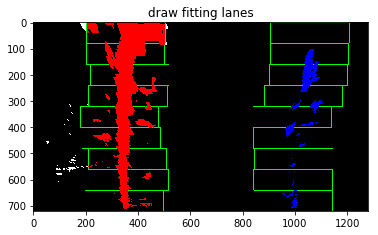

left_fit:  [  2.02561356e-04  -1.80611813e-01   3.89426959e+02]
right_fit:  [  1.01497088e-04  -2.26624931e-01   1.09544676e+03]


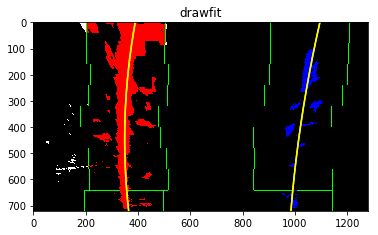

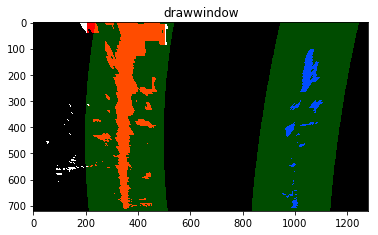

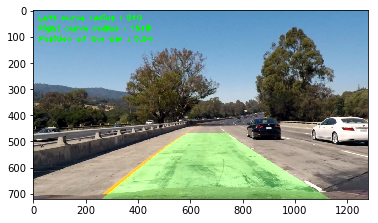

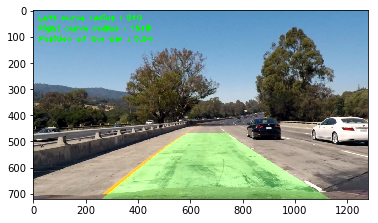

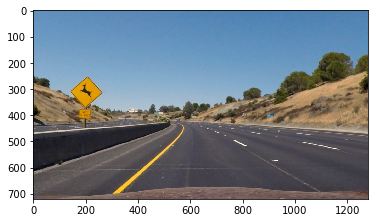

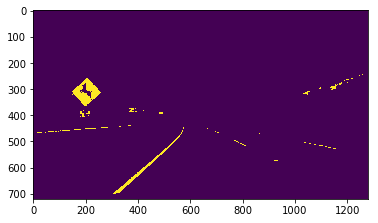

warpped shape:  (720, 1280)


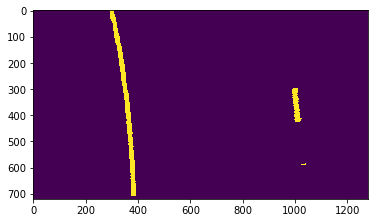

out_img.shape : (720, 1280, 3)
midpoint : 640 leftx_base : 376 rightx_base : 1002
nonzero : (array([  0,   0,   0, ..., 709, 709, 709]), array([292, 293, 294, ..., 389, 390, 391])) nonzeroy : [  0   0   0 ..., 709 709 709] (15853,) nonzerox : [292 293 294 ..., 389 390 391] (15853,)
y_eval :  719.0
left_fit_cr[0] :  -0.000411589808892 right_fit_cr[0] :  0.000398744156324
car_pos : 640.0 lane_center : 643.953885035
x axis offset in meters: 0.0208991066145


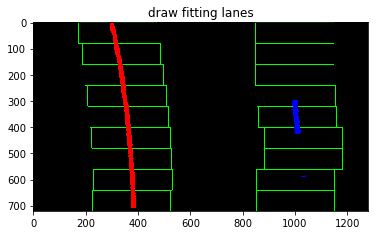

left_fit:  [ -1.35188094e-04   2.13109395e-01   3.00262535e+02]
right_fit:  [  1.30968895e-04   1.92246381e-03   9.87645235e+02]


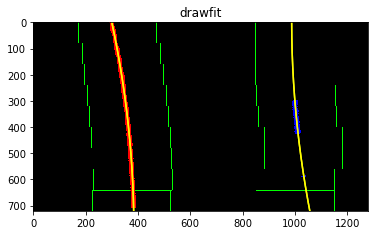

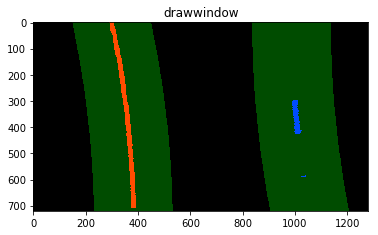

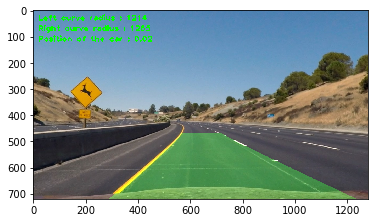

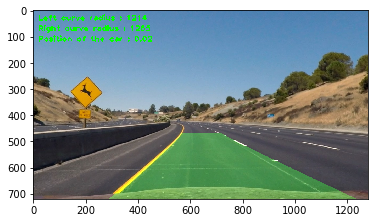

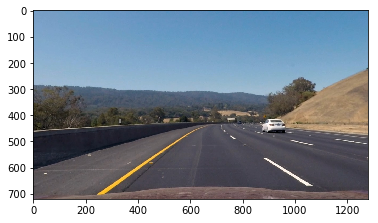

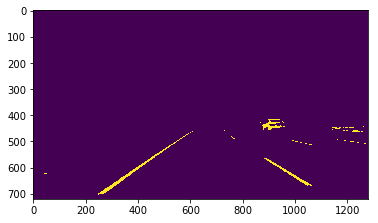

warpped shape:  (720, 1280)


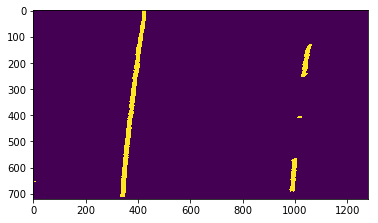

out_img.shape : (720, 1280, 3)
midpoint : 640 leftx_base : 352 rightx_base : 996
nonzero : (array([  0,   0,   0, ..., 711, 718, 718]), array([415, 416, 417, ..., 338, 828, 829])) nonzeroy : [  0   0   0 ..., 711 718 718] (17946,) nonzerox : [415 416 417 ..., 338 828 829] (17946,)
y_eval :  719.0
left_fit_cr[0] :  0.000155626665592 right_fit_cr[0] :  0.00029927420122
car_pos : 640.0 lane_center : 751.91614391
x axis offset in meters: 0.591556760666


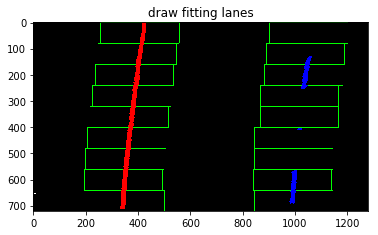

left_fit:  [  5.11161158e-05  -1.57156773e-01   4.26897218e+02]
right_fit:  [  9.82976449e-05  -1.93174106e-01   1.07693507e+03]


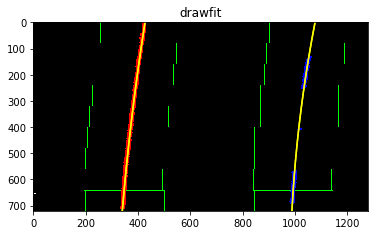

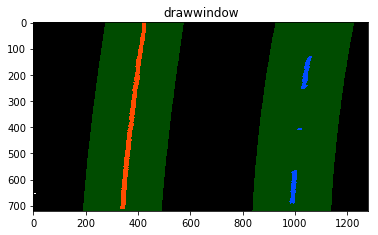

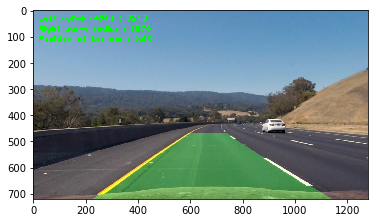

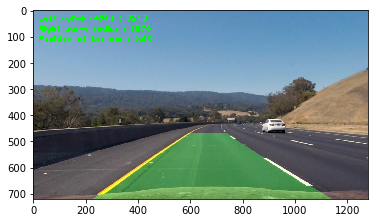

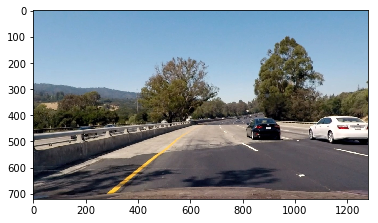

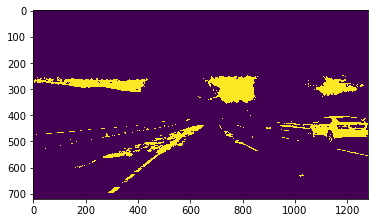

warpped shape:  (720, 1280)


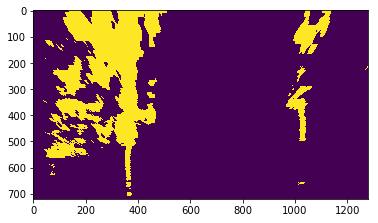

out_img.shape : (720, 1280, 3)
midpoint : 640 leftx_base : 365 rightx_base : 1023
nonzero : (array([  0,   0,   0, ..., 708, 708, 708]), array([133, 134, 135, ..., 371, 372, 373])) nonzeroy : [  0   0   0 ..., 708 708 708] (148112,) nonzerox : [133 134 135 ..., 371 372 373] (148112,)
y_eval :  719.0
left_fit_cr[0] :  0.00027637117898 right_fit_cr[0] :  0.00192061235719
car_pos : 640.0 lane_center : 697.718847853
x axis offset in meters: 0.30508533865


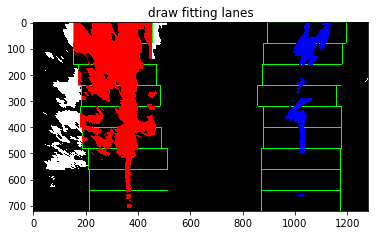

left_fit:  [  9.07750682e-05   4.03570389e-02   3.00046145e+02]
right_fit:  [  6.30831761e-04  -4.51300563e-01   1.09539155e+03]


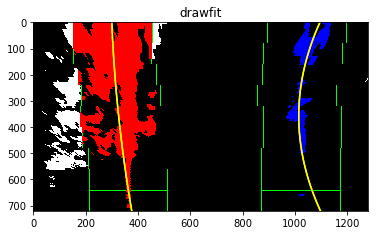

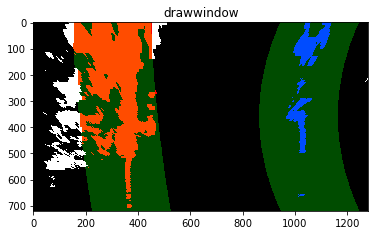

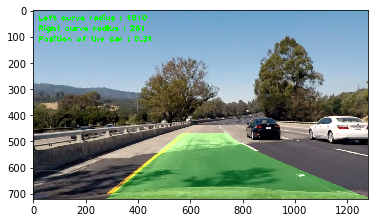

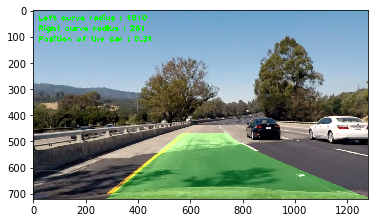

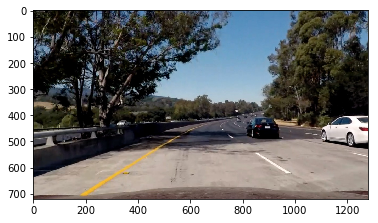

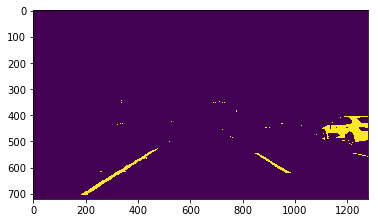

warpped shape:  (720, 1280)


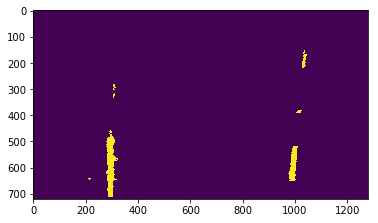

out_img.shape : (720, 1280, 3)
midpoint : 640 leftx_base : 294 rightx_base : 997
nonzero : (array([154, 154, 154, ..., 712, 712, 712]), array([1037, 1038, 1039, ...,  304,  305,  306])) nonzeroy : [154 154 154 ..., 712 712 712] (10225,) nonzerox : [1037 1038 1039 ...,  304  305  306] (10225,)
y_eval :  719.0
left_fit_cr[0] :  0.00039197968934 right_fit_cr[0] :  6.82111545126e-05
car_pos : 640.0 lane_center : 701.717242283
x axis offset in meters: 0.326219709208


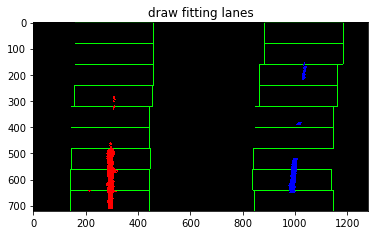

left_fit:  [  1.28747083e-04  -1.60886193e-01   3.45264622e+02]
right_fit:  [  2.24041893e-05  -1.22201651e-01   1.05816986e+03]


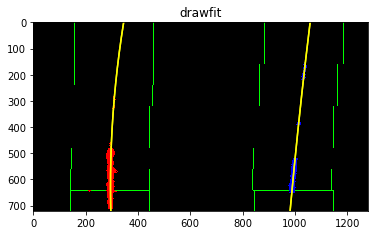

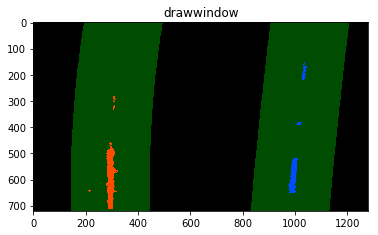

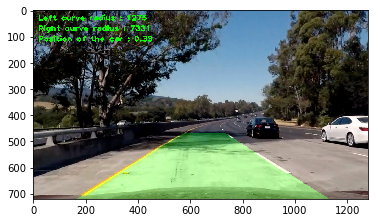

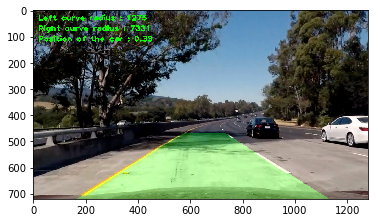

In [12]:

def process_one_image(image, debug = False):
#    Line.image = image
    undistorted = undistortImg(image)
    if (True == debug):
        plt.imshow(undistorted)
        plt.show()
    colorgrad = thresholding(undistorted) #(image, (180, 255), (60, 100) )
    if (True == debug):
        plt.imshow(colorgrad)
        plt.show()
    warped, M, Minv = warp_image(colorgrad, src, dst)
    if (True == debug):
        print('warpped shape: ', warped.shape)
        plt.imshow(warped)
        plt.show()

#    left_fit, right_fit = fitlanes(warped)
    fitlanes(debug)
    left_fitx, right_fitx, ploty, out_img = drawfit(debug)
    if (True == debug):
        plt.imshow(out_img)
        plt.title('drawfit')

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    
    drawwindow(debug)
#    warpedback = drawwarpback(left_fitx, right_fitx, ploty)
    drawwarpback()
    
    warpedback = frame.warped_combined
    if (True == debug):
        plt.imshow(warpedback)
        plt.show()
    return warpedback

def process_image(image, debug = False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # turn on debug to produce some image, for debugging or the writeups.
    # debug = True
    return process_one_image(image)


# filename = 'test_images/straight_lines2.jpg'
# filename = 'test_images/test2.jpg'
# test files:
for num in range(1, 6):
    filename = 'test_images/test' + str(num) + '.jpg'
    image = mpimg.imread(filename)
    processed = process_one_image(image, True)
    plt.imshow(processed)
    plt.show()



In [13]:
interrupt

NameError: name 'interrupt' is not defined

In [ ]:
# Todo: use warpfromlastframe to speed up?

# make sure the output folder exist.
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputdir = 'test_videos_output'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
white_output = outputdir + '/project-output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(22,26)
#clip1 = VideoFileClip("project_video.mp4").subclip(39,43)
#clip1 = VideoFileClip("project_video.mp4")

#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)




In [ ]:
interrupt

In [ ]:
# Todo: use warpfromlastframe to speed up?
# make sure the output folder exist.
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputdir = 'test_videos_output'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
white_output = outputdir + '/harder-project-output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip1 = VideoFileClip("harder_challenge_video.mp4")

#clip1 = VideoFileClip("harder-challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

